<a href="https://colab.research.google.com/github/akaliutau/ai-material-science/blob/main/notebooks/domain_agnostic_reasoning_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Domain-Agnostic Reasoning Analysis (Two-Domain, Four-arms)

This notebook evaluates whether our **reasoning improvements are domain-agnostic** by comparing results across **two domains**, each with **four experimental arms**:
- `baseline`
- `raw_text`
- `raw_text_contract` (raw text + contract)
- `contract`

It **does not repeat** the deep-dives from the earlier notebook and instead focuses on **aggregated comparisons, effect sizes, correlations, and robustness checks** across domains.

**Assumptions about data files**
- Each JSON file contains a **list of objects** with a stable schema (see `snippet_1` in the project).
- Every record contains at least:
  - `gold_answer` in `[0, 1]`, where `1.0 = strongly agree`, `0.0 = strongly disagree`, `0.5 = uncertain`.
  - `eval_score`: an LLM trace-similarity score **independent** of `gold_answer` and model predictions.
- If available, a **predicted** field like `pred_answer` (or a variant) will be used to compute continuous performance.
- The eight files cover two domains × four arms each.

> **Goal:** Show that improvements (particularly with contracts) generalize across domains, as evidenced by consistent effect sizes and correlations.



## 1) Quick Start

- Put your **8 JSON files** somewhere accessible (local path or mounted path).
- Update the mapping below with filepaths → `(domain, arm)`.
- Run the notebook cells top-to-bottom.

> The loader is flexible: it accepts **JSON arrays** or **JSONL** (one JSON object per line).


In [ ]:

# --- User Configuration ---
# Map each filepath to (domain, arm). Two domains × four arms.
FILE_MAP = {
    "/home/perovskites_baseline.json": ("perovskites", "baseline"),
    "/home/perovskites_raw_text.json": ("perovskites", "raw_text"),
    "/home/perovskites_raw_text_contract.json": ("perovskites", "raw_text_contract"),
    "/home/perovskites_contract.json": ("perovskites", "contract"),
    "/home/superconductors_baseline.json": ("superconductors", "baseline"),
    "/home/superconductors_raw_text.json": ("superconductors", "raw_text"),
    "/home/superconductors_raw_text_contract.json": ("superconductors", "raw_text_contract"),
    "/home/superconductors_contract.json": ("superconductors", "contract"),
}

USE_DOMAIN_arm_FROM_FILES_IF_PRESENT = False

# Candidate column names for model predictions. The first one found will be used.
PRED_CANDIDATES = ["pred_answer", "model_answer", "model_pred", "prediction", "answer"]

# Primary columns expected to exist:
GOLD_COL = "gold_answer"         # Ground truth in [0, 1]
EVAL_COL = "eval_score"          # LLM trace-similarity score (independent of gold/pred)

# Threshold (in absolute error) for a "binary" correctness proxy; used only for reference plots.
# E.g., threshold 0.15 means |pred - gold| <= 0.15 counts as correct.
BINARY_THRESH = 0.15

# Random seed for bootstrap reproducibility
SEED = 42



## 2) Imports & Utilities
The analysis uses **standard scientific Python**. No seaborn is used; all plots rely on **matplotlib** with default colors.


In [ ]:

import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from typing import List, Dict

np.random.seed(SEED)

def _load_one_json_file(path: str) -> List[Dict]:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if not isinstance(data, list):
        raise ValueError(f"File {path} does not contain a top-level JSON list.")
    return data

def load_files(file_map, use_domain_arm_from_files=False):
    frames = []
    for fp, (domain, arm) in file_map.items():
        if not os.path.exists(fp):
            raise ValueError(f"File not found: {fp}")
        data = _load_one_json_file(fp)
        df = pd.DataFrame(data)
        df["source_file"] = str(fp)
        df["domain"] = domain
        df["arm"] = arm
        frames.append(df)
    if not frames:
        raise ValueError("No files loaded. Please populate FILE_MAP or set USE_DOMAIN_arm_FROM_FILES_IF_PRESENT=True with files that include `domain` and `arm`.")
    out = pd.concat(frames, axis=0, ignore_index=True)
    return out

def find_prediction_column(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def bootstrap_mean_ci(x, n_boot=2000, ci=95):
    x = pd.Series(x).dropna().astype(float).values
    if len(x) == 0:
        return np.nan, np.nan, np.nan
    rng = np.random.default_rng(SEED)
    means = np.empty(n_boot, dtype=float)
    n = len(x)
    for i in range(n_boot):
        sample = rng.choice(x, size=n, replace=True)
        means[i] = sample.mean()
    alpha = 100 - ci
    lo, hi = np.percentile(means, [alpha/2, 100 - (alpha/2)])
    return float(x.mean()), float(lo), float(hi)

def bootstrap_diff_means_ci(a, b, n_boot=2000, ci=95):
    '''
    Bootstrap CI for difference in means: mean(a) - mean(b).
    '''
    a = pd.Series(a).dropna().astype(float).values
    b = pd.Series(b).dropna().astype(float).values
    if len(a) == 0 or len(b) == 0:
        return np.nan, np.nan, np.nan
    rng = np.random.default_rng(SEED)
    diffs = np.empty(n_boot, dtype=float)
    for i in range(n_boot):
        sa = rng.choice(a, size=len(a), replace=True)
        sb = rng.choice(b, size=len(b), replace=True)
        diffs[i] = sa.mean() - sb.mean()
    alpha = 100 - ci
    lo, hi = np.percentile(diffs, [alpha/2, 100 - (alpha/2)])
    return float(a.mean() - b.mean()), float(lo), float(hi)

def cohens_d_independent(a, b):
    '''
    Cohen's d for two independent samples.
    '''
    a = pd.Series(a).dropna().astype(float).values
    b = pd.Series(b).dropna().astype(float).values
    if len(a) < 2 or len(b) < 2:
        return np.nan
    nx, ny = len(a), len(b)
    vx, vy = a.var(ddof=1), b.var(ddof=1)
    s = np.sqrt(((nx - 1) * vx + (ny - 1) * vy) / (nx + ny - 2))
    if s == 0:
        return np.nan
    return (a.mean() - b.mean()) / s

def cliffs_delta(a, b, max_pairs=50000):
    '''
    Cliff's delta: P(a > b) - P(a < b).
    For large samples, sub-sample pairs for speed.
    '''
    a = pd.Series(a).dropna().astype(float).values
    b = pd.Series(b).dropna().astype(float).values
    if len(a) == 0 or len(b) == 0:
        return np.nan
    rng = np.random.default_rng(SEED)
    n_pairs = len(a) * len(b)
    if n_pairs > max_pairs:
        idx_a = rng.choice(len(a), size=int(np.sqrt(max_pairs)), replace=True)
        idx_b = rng.choice(len(b), size=int(np.sqrt(max_pairs)), replace=True)
        a_s, b_s = a[idx_a], b[idx_b]
    else:
        a_s, b_s = a, b
    greater = 0
    less = 0
    for ai in a_s:
        greater += np.sum(ai > b_s)
        less += np.sum(ai < b_s)
    denom = len(a_s) * len(b_s)
    return (greater - less) / denom

def spearman_corr(x, y):
    s = pd.Series(x).astype(float).corr(pd.Series(y).astype(float), method="spearman")
    return float(s) if not np.isnan(s) else np.nan

# Matplotlib settings: single chart per figure; defaults only (no custom colors/styles)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 110



## 3) Load & Inspect
We load all eight files, attach `(domain, arm)`, and verify the schema.


In [ ]:

# Load
df = load_files(FILE_MAP, use_domain_arm_from_files=USE_DOMAIN_arm_FROM_FILES_IF_PRESENT)

# Ensure required columns exist
missing = [c for c in [GOLD_COL, EVAL_COL, "domain", "arm"] if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Identify prediction column if present
PRED_COL = find_prediction_column(df, PRED_CANDIDATES)
print("Detected prediction column:", PRED_COL)

# Basic inspection
print("Rows:", len(df))
print("Domains:", df["domain"].unique())
print("arms:", df["arm"].unique())
df.head(3)


Detected prediction column: pred_answer
Rows: 692
Domains: ['perovskites' 'superconductors']
arms: ['baseline' 'raw_text' 'raw_text_contract' 'contract']


,question_id,question,experiment_id,config_name,question_type,gold_answer,gold_trace,pred_answer,pred_trace,notes,prompt_tokens,completion_tokens,latency,eval_score,source_file,domain,arm
0,1-1,To what extent do you agree with the following...,test-pervos,o3-mini,Structural–electronic coupling,0.05,Experiment shows the opposite: cooling contrac...,0.7,The claim proposes that cooling leads to an an...,Requires linking thermally driven structural d...,1275,2814,34210,0.0,/home/perovskites_baseline.json,perovskites,baseline
1,1-2,Evaluate the statement: “At 150 K under a 3 T...,test-pervos,o3-mini,Anisotropic magnetostriction,0.15,Rietveld data show the b-axis shrinks more tha...,0.9,The statement emphasizes that the largest latt...,Demands recall of axis-specific strain values ...,1275,2814,34210,0.0,/home/perovskites_baseline.json,perovskites,baseline
2,1-3,“According to charge-transfer multiplet simula...,test-pervos,o3-mini,Temperature-driven electronic parameters,0.9,All listed trends match the reported simulatio...,0.8,The synthesis proposes that cooling increases ...,Requires integrating numerical change (1.1 eV)...,1275,2814,34210,0.9,/home/perovskites_baseline.json,perovskites,baseline



## 4) Prepare Metrics
We derive **continuous performance** and **binary correctness** (with a small tolerance), when a prediction column exists. We always keep `eval_score` intact.


In [ ]:

# Copy to avoid SettingWithCopy issues
data = df.copy()

# Coerce to floats in [0, 1]
data[GOLD_COL] = pd.to_numeric(data[GOLD_COL], errors="coerce").clip(0, 1)
data[EVAL_COL] = pd.to_numeric(data[EVAL_COL], errors="coerce")

# Derive performance columns if we have predictions
if PRED_COL is not None and PRED_COL in data.columns:
    data[PRED_COL] = pd.to_numeric(data[PRED_COL], errors="coerce").clip(0, 1)
    data["abs_err"] = (data[PRED_COL] - data[GOLD_COL]).abs()
    data["score_cont"] = 1.0 - data["abs_err"]
    data["correct_bin"] = (data["abs_err"] <= BINARY_THRESH).astype(int)
else:
    data["abs_err"] = np.nan
    data["score_cont"] = np.nan
    data["correct_bin"] = np.nan

# Clean arm ordering
cond_order = ["baseline", "raw_text", "raw_text_contract", "contract"]
data["arm"] = pd.Categorical(data["arm"], categories=cond_order, ordered=True)

# Sanity checks
display_cols = [c for c in [GOLD_COL, PRED_COL, EVAL_COL, "abs_err", "score_cont", "correct_bin", "domain", "arm", "source_file"] if c is not None]
data[display_cols].head(5)


,gold_answer,pred_answer,eval_score,abs_err,score_cont,correct_bin,domain,arm,source_file
0,0.05,0.7,0.0,0.65,0.35,0,perovskites,baseline,/home/perovskites_baseline.json
1,0.15,0.9,0.0,0.75,0.25,0,perovskites,baseline,/home/perovskites_baseline.json
2,0.90,0.8,0.9,0.10,0.90,1,perovskites,baseline,/home/perovskites_baseline.json
3,0.10,0.7,0.0,0.60,0.40,0,perovskites,baseline,/home/perovskites_baseline.json
4,0.10,0.3,0.2,0.20,0.80,0,perovskites,baseline,/home/perovskites_baseline.json



## 5) Aggregated Comparisons by Domain & arm
We start with **mean** metrics and **95% bootstrap CIs** for each domain × arm. We emphasize **aggregated** charts to compare trends across domains.

- `eval_score` (always available)
- `score_cont` (if predictions exist)
- `correct_bin` (if predictions exist; uses a small tolerance only as a sanity proxy)


In [ ]:
def aggregate_bootstrap(df, metric):
    rows = []
    for (d, c), g in df.groupby(["domain", "arm"]):
        m, lo, hi = bootstrap_mean_ci(g[metric])
        rows.append({"domain": d, "arm": c, "metric": metric, "mean": m, "ci_lo": lo, "ci_hi": hi, "n": len(g)})
    agg_df = pd.DataFrame(rows)
    # Ensure arm column is categorical with the correct order
    cond_order = ["baseline", "raw_text", "raw_text_contract", "contract"]
    agg_df["arm"] = pd.Categorical(agg_df["arm"], categories=cond_order, ordered=True)
    return agg_df.sort_values(["domain", "arm"])

agg_eval = aggregate_bootstrap(data, EVAL_COL)
if "score_cont" in data.columns:
    agg_score = aggregate_bootstrap(data, "score_cont")
else:
    agg_score = pd.DataFrame()

if "correct_bin" in data.columns:
    agg_correct = aggregate_bootstrap(data, "correct_bin")
else:
    agg_correct = pd.DataFrame()

agg_eval.head(8)

/tmp/ipython-input-221254668.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (d, c), g in df.groupby(["domain", "arm"]):
/tmp/ipython-input-221254668.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (d, c), g in df.groupby(["domain", "arm"]):
/tmp/ipython-input-221254668.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (d, c), g in df.groupby(["domain", "arm"]):


,domain,arm,metric,mean,ci_lo,ci_hi,n
0,perovskites,baseline,eval_score,0.659091,0.581818,0.736881,99
1,perovskites,raw_text,eval_score,0.800000,0.732222,0.863333,90
2,perovskites,raw_text_contract,eval_score,0.848889,0.788889,0.902222,90
3,perovskites,contract,eval_score,0.833000,0.772000,0.887000,100
4,superconductors,baseline,eval_score,0.780488,0.698750,0.862195,82
5,superconductors,raw_text,eval_score,0.793902,0.710976,0.873201,82
6,superconductors,raw_text_contract,eval_score,0.843537,0.767927,0.910619,82
7,superconductors,contract,eval_score,0.852239,0.768657,0.922388,67


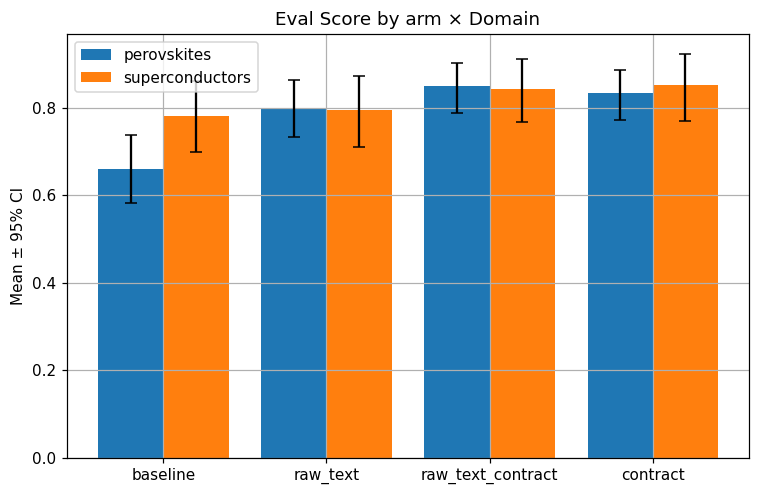

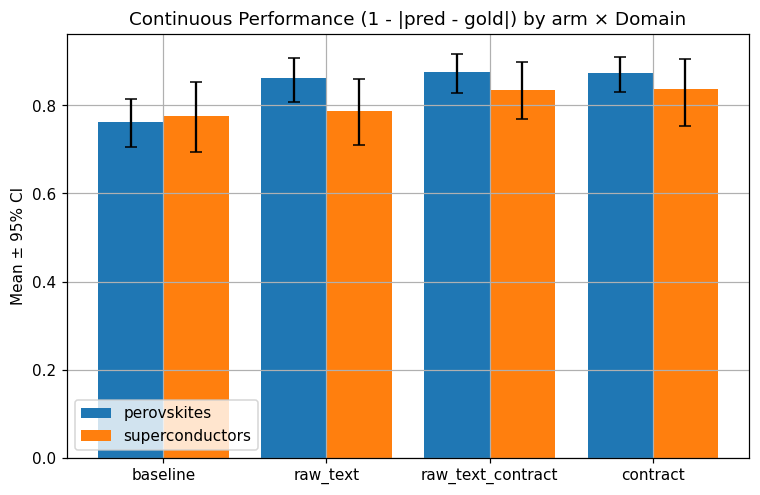

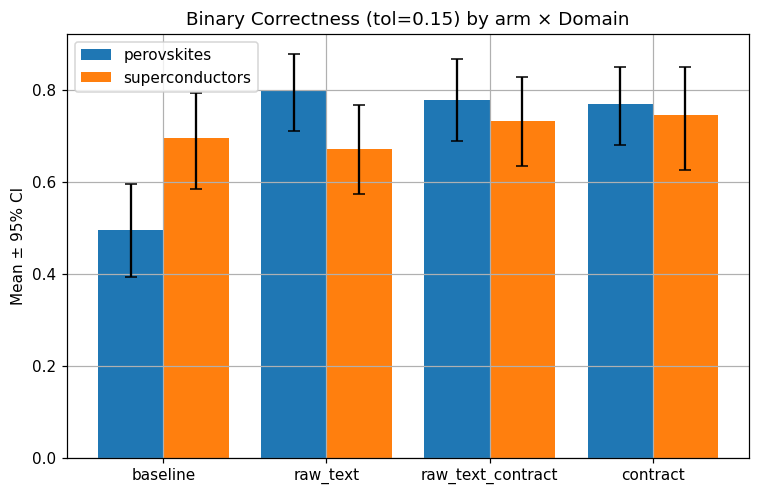

In [ ]:

def plot_bar_with_ci(df_metric, title):
    if df_metric.empty:
        print(f"[Skip] No data for: {title}")
        return

    pivot = df_metric.pivot(index="arm", columns="domain", values="mean").reindex(index=df_metric["arm"].cat.categories)
    err_lo = df_metric.pivot(index="arm", columns="domain", values="ci_lo").reindex(index=df_metric["arm"].cat.categories)
    err_hi = df_metric.pivot(index="arm", columns="domain", values="ci_hi").reindex(index=df_metric["arm"].cat.categories)

    domains = list(pivot.columns)
    x = np.arange(len(pivot.index))
    width = 0.8 / max(1, len(domains))

    fig = plt.figure()
    for i, d in enumerate(domains):
        means = pivot[d].values.astype(float)
        los = err_lo[d].values.astype(float)
        his = err_hi[d].values.astype(float)
        yerr = np.vstack([means - los, his - means])
        plt.bar(x + i * width, means, width, yerr=yerr, capsize=4, label=str(d))
    plt.xticks(x + (len(domains)-1)*width/2, pivot.index.astype(str), rotation=0)
    plt.ylabel("Mean ± 95% CI")
    plt.title(title)
    plt.legend()
    plt.show()

plot_bar_with_ci(agg_eval, f"Eval Score by arm × Domain")
if not agg_score.empty:
    plot_bar_with_ci(agg_score, f"Continuous Performance (1 - |pred - gold|) by arm × Domain")
if not agg_correct.empty:
    plot_bar_with_ci(agg_correct, f"Binary Correctness (tol={BINARY_THRESH}) by arm × Domain")



## 6) Effect Sizes vs. Baseline (per Domain) — Forest Plots
To directly answer the **domain-agnostic** question, we compute effect sizes of each arm **relative to `baseline`** **within each domain**. We report:

- **Δ mean** (difference in means) with bootstrap 95% CI
- **Cohen's d** (independent samples)
- **Cliff's delta** (robust, nonparametric)

We visualize these as **forest plots** to show whether the contract-based improvements are consistent across domains.


In [ ]:

def effects_vs_baseline(df, metric):
    rows = []
    for d, g in df.groupby("domain"):
        base = g.loc[g["arm"] == "baseline", metric].dropna()
        for cond in ["raw_text", "raw_text_contract", "contract"]:
            cur = g.loc[g["arm"] == cond, metric].dropna()
            if len(base) == 0 or len(cur) == 0:
                rows.append({"domain": d, "metric": metric, "arm": cond,
                             "diff_mean": np.nan, "diff_lo": np.nan, "diff_hi": np.nan,
                             "cohens_d": np.nan, "cliffs_delta": np.nan, "n_base": len(base), "n_cond": len(cur)})
                continue
            dm, lo, hi = bootstrap_diff_means_ci(cur, base)  # (cond - baseline)
            cd = cohens_d_independent(cur, base)
            cl = cliffs_delta(cur, base)
            rows.append({"domain": d, "metric": metric, "arm": cond,
                         "diff_mean": dm, "diff_lo": lo, "diff_hi": hi,
                         "cohens_d": cd, "cliffs_delta": cl, "n_base": len(base), "n_cond": len(cur)})
    return pd.DataFrame(rows).sort_values(["metric", "domain", "arm"])

eff_eval = effects_vs_baseline(data, EVAL_COL)
if "score_cont" in data.columns:
    eff_score = effects_vs_baseline(data, "score_cont")
else:
    eff_score = pd.DataFrame()

eff_eval


,domain,metric,arm,diff_mean,diff_lo,diff_hi,cohens_d,cliffs_delta,n_base,n_cond
2,perovskites,eval_score,contract,0.173909,0.072992,0.273160,0.503441,0.278081,99,100
0,perovskites,eval_score,raw_text,0.140909,0.031611,0.241321,0.392130,0.205163,99,90
1,perovskites,eval_score,raw_text_contract,0.189798,0.092318,0.282129,0.559077,0.299663,99,90
5,superconductors,eval_score,contract,0.071751,-0.043508,0.182766,0.202387,0.066800,82,67
3,superconductors,eval_score,raw_text,0.013415,-0.102439,0.126829,0.035330,0.024242,82,82
4,superconductors,eval_score,raw_text_contract,0.063049,-0.050732,0.168433,0.176892,0.087597,82,82


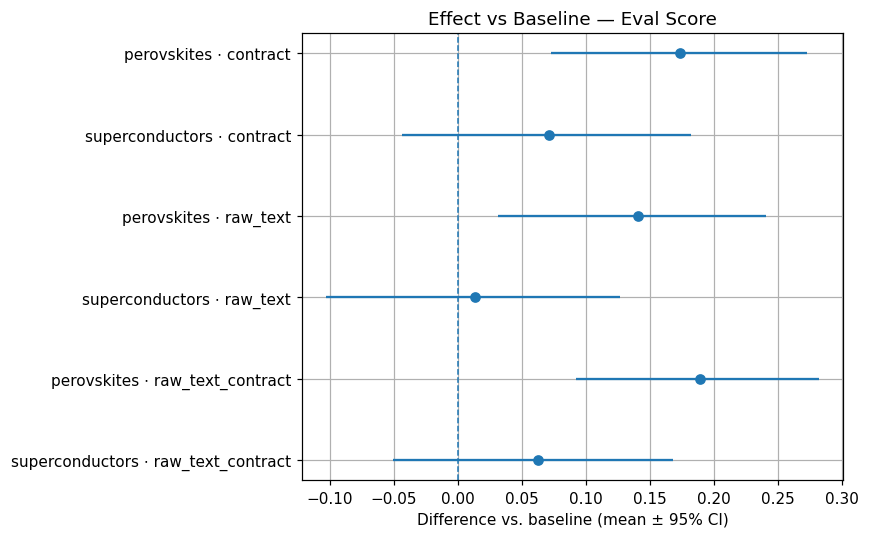

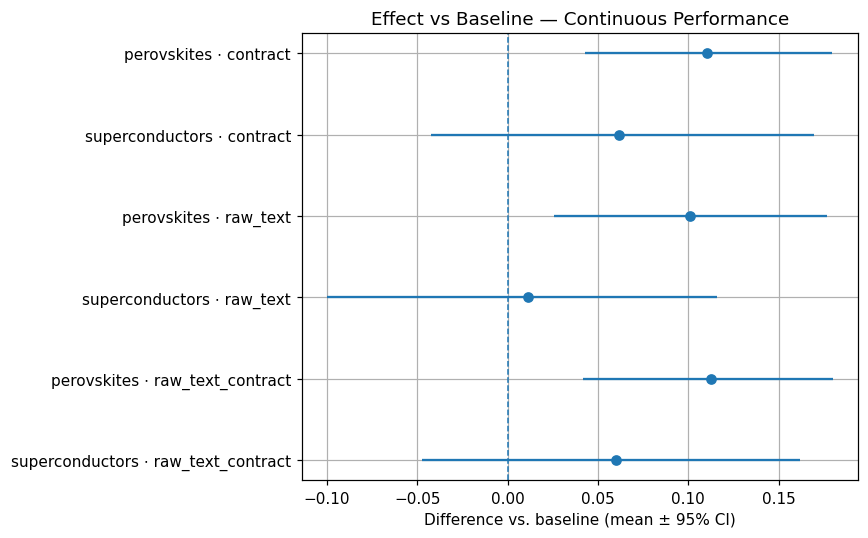

In [ ]:

def forest_plot_effects(df_eff, title, effect_col="diff_mean", lo_col="diff_lo", hi_col="diff_hi"):
    if df_eff.empty:
        print(f"[Skip] No data for: {title}")
        return

    df_plot = df_eff.copy()
    df_plot["label"] = df_plot["domain"].astype(str) + " ⋅ " + df_plot["arm"].astype(str)
    df_plot = df_plot.sort_values(["arm", "domain"])

    y_pos = np.arange(len(df_plot))[::-1]
    effect = df_plot[effect_col].values.astype(float)
    lo = df_plot[lo_col].values.astype(float)
    hi = df_plot[hi_col].values.astype(float)

    fig = plt.figure()
    plt.hlines(y=y_pos, xmin=lo, xmax=hi)
    plt.plot(effect, y_pos, "o")
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.yticks(y_pos, df_plot["label"].tolist())
    plt.xlabel("Difference vs. baseline (mean ± 95% CI)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

forest_plot_effects(eff_eval, f"Effect vs Baseline — Eval Score")
if not eff_score.empty:
    forest_plot_effects(eff_score, f"Effect vs Baseline — Continuous Performance")


In [ ]:

# Show effect size tables with Cohen's d and Cliff's delta for reporting
def small_table(df_eff, metric_name):
    keep = df_eff[["domain", "arm", "diff_mean", "diff_lo", "diff_hi", "cohens_d", "cliffs_delta", "n_base", "n_cond"]].copy()
    keep = keep.sort_values(["domain", "arm"])
    keep.insert(0, "metric", metric_name)
    return keep

tbl_eff_eval = small_table(eff_eval, "eval_score")
display(tbl_eff_eval.head(12))

if not eff_score.empty:
    tbl_eff_score = small_table(eff_score, "score_cont")
    display(tbl_eff_score.head(12))


,metric,domain,arm,diff_mean,diff_lo,diff_hi,cohens_d,cliffs_delta,n_base,n_cond
2,eval_score,perovskites,contract,0.173909,0.072992,0.273160,0.503441,0.278081,99,100
0,eval_score,perovskites,raw_text,0.140909,0.031611,0.241321,0.392130,0.205163,99,90
1,eval_score,perovskites,raw_text_contract,0.189798,0.092318,0.282129,0.559077,0.299663,99,90
5,eval_score,superconductors,contract,0.071751,-0.043508,0.182766,0.202387,0.066800,82,67
3,eval_score,superconductors,raw_text,0.013415,-0.102439,0.126829,0.035330,0.024242,82,82
4,eval_score,superconductors,raw_text_contract,0.063049,-0.050732,0.168433,0.176892,0.087597,82,82


,metric,domain,arm,diff_mean,diff_lo,diff_hi,cohens_d,cliffs_delta,n_base,n_cond
2,score_cont,perovskites,contract,0.110374,0.043052,0.179401,0.458848,0.274848,99,100
0,score_cont,perovskites,raw_text,0.100707,0.025848,0.176717,0.392261,0.294949,99,90
1,score_cont,perovskites,raw_text_contract,0.112655,0.041778,0.179934,0.457208,0.293383,99,89
5,score_cont,superconductors,contract,0.061704,-0.042467,0.169355,0.180110,0.060976,82,67
3,score_cont,superconductors,raw_text,0.010976,-0.100000,0.115854,0.030433,0.018441,82,82
4,score_cont,superconductors,raw_text_contract,0.059756,-0.047561,0.161601,0.175958,0.081499,82,82



## 7) Domain-Independence: Interaction Checks via Bootstrap
We test whether the **treatment effects differ by domain** (i.e., a `domain × arm` interaction). For each arm (vs. baseline), we compute the **difference of effects** between domains and obtain a **bootstrap 95% CI**.

If the CI for the **difference-of-differences** includes `0` and is tight, it supports **domain-agnostic** improvements.


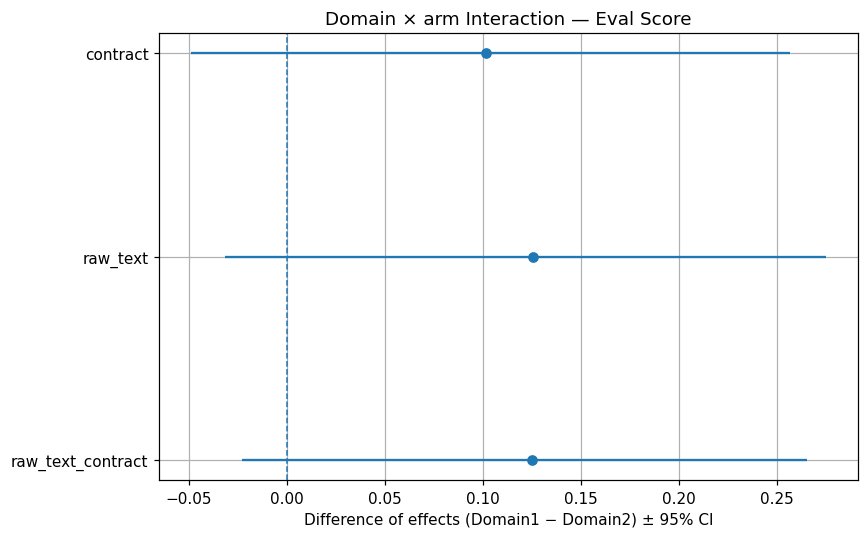

,arm,mean_diff_of_diff,ci_lo,ci_hi,domains
2,contract,0.101474,-0.048853,0.256552,"[perovskites, superconductors]"
0,raw_text,0.125742,-0.031537,0.275043,"[perovskites, superconductors]"
1,raw_text_contract,0.125004,-0.022984,0.265479,"[perovskites, superconductors]"


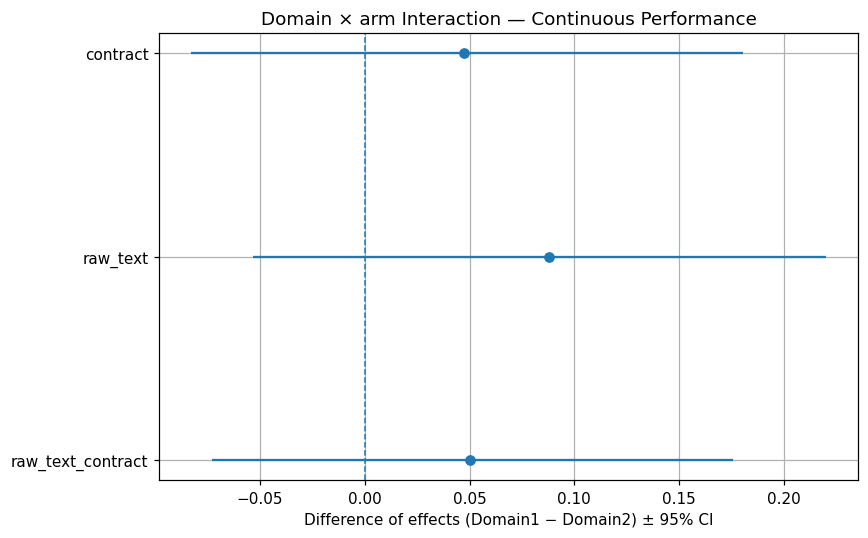

,arm,mean_diff_of_diff,ci_lo,ci_hi,domains
2,contract,0.047402,-0.082876,0.180298,"[perovskites, superconductors]"
0,raw_text,0.087902,-0.053350,0.220135,"[perovskites, superconductors]"
1,raw_text_contract,0.050111,-0.072763,0.175444,"[perovskites, superconductors]"


In [ ]:

def effect_by_domain(df, metric, cond):
    out = {}
    for d, g in df.groupby("domain"):
        base = g.loc[g["arm"] == "baseline", metric].dropna().values
        cur = g.loc[g["arm"] == cond, metric].dropna().values
        if len(base) and len(cur):
            out[d] = (cur, base)
    return out

def bootstrap_interaction_ci(df, metric, cond, n_boot=2000, ci=95):
    ed = effect_by_domain(df, metric, cond)
    if len(ed) != 2:
        return np.nan, np.nan, np.nan, list(ed.keys())
    domains = list(ed.keys())
    (a_cur, a_base) = ed[domains[0]]
    (b_cur, b_base) = ed[domains[1]]
    rng = np.random.default_rng(SEED)
    diffs = np.empty(n_boot, dtype=float)
    for i in range(n_boot):
        # resample within each domain independently
        sa_cur = rng.choice(a_cur, size=len(a_cur), replace=True)
        sa_base = rng.choice(a_base, size=len(a_base), replace=True)
        sb_cur = rng.choice(b_cur, size=len(b_cur), replace=True)
        sb_base = rng.choice(b_base, size=len(b_base), replace=True)

        eff_a = sa_cur.mean() - sa_base.mean()
        eff_b = sb_cur.mean() - sb_base.mean()
        diffs[i] = eff_a - eff_b  # difference-of-differences
    alpha = 100 - ci
    lo, hi = np.percentile(diffs, [alpha/2, 100 - (alpha/2)])
    return float(diffs.mean()), float(lo), float(hi), domains

def interaction_forest(df, metric, title):
    rows = []
    for cond in ["raw_text", "raw_text_contract", "contract"]:
        m, lo, hi, doms = bootstrap_interaction_ci(df, metric, cond)
        rows.append({"arm": cond, "mean_diff_of_diff": m, "ci_lo": lo, "ci_hi": hi, "domains": doms})
    plot_df = pd.DataFrame(rows)
    plot_df = plot_df.sort_values("arm")
    y = np.arange(len(plot_df))[::-1]

    fig = plt.figure()
    plt.hlines(y=y, xmin=plot_df["ci_lo"].values, xmax=plot_df["ci_hi"].values)
    plt.plot(plot_df["mean_diff_of_diff"].values, y, "o")
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.yticks(y, plot_df["arm"].tolist())
    plt.xlabel("Difference of effects (Domain1 − Domain2) ± 95% CI")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return plot_df

inter_eval = interaction_forest(data, EVAL_COL, "Domain × arm Interaction — Eval Score")
display(inter_eval)

if "score_cont" in data.columns:
    inter_score = interaction_forest(data, "score_cont", "Domain × arm Interaction — Continuous Performance")
    display(inter_score)



## 8) Eval Score ↔ Performance Coupling
Although `eval_score` is computed independently of predictions, we verify whether **higher eval_score aligns with better performance** in each domain and arm.

We report **Spearman correlations** and show an aggregated **scatter** (with jitter) by arm.


In [ ]:

def compute_spearman_grid(df):
    rows = []
    if "score_cont" not in df.columns or df["score_cont"].isna().all():
        print("[Skip] No predictions found; cannot compute performance correlations.")
        return pd.DataFrame()
    for (d, c), g in df.groupby(["domain", "arm"]):
        s = spearman_corr(g[EVAL_COL], g["score_cont"])
        rows.append({"domain": d, "arm": c, "spearman_eval_vs_perf": s, "n": len(g)})
    out = pd.DataFrame(rows).sort_values(["domain", "arm"])
    return out

grid_corr = compute_spearman_grid(data)
grid_corr.head(8)


/tmp/ipython-input-2025982059.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (d, c), g in df.groupby(["domain", "arm"]):


,domain,arm,spearman_eval_vs_perf,n
0,perovskites,baseline,0.693298,99
3,perovskites,contract,0.408514,100
1,perovskites,raw_text,0.474117,90
2,perovskites,raw_text_contract,0.372409,90
4,superconductors,baseline,0.637098,82
7,superconductors,contract,0.704899,67
5,superconductors,raw_text,0.811978,82
6,superconductors,raw_text_contract,0.709806,82


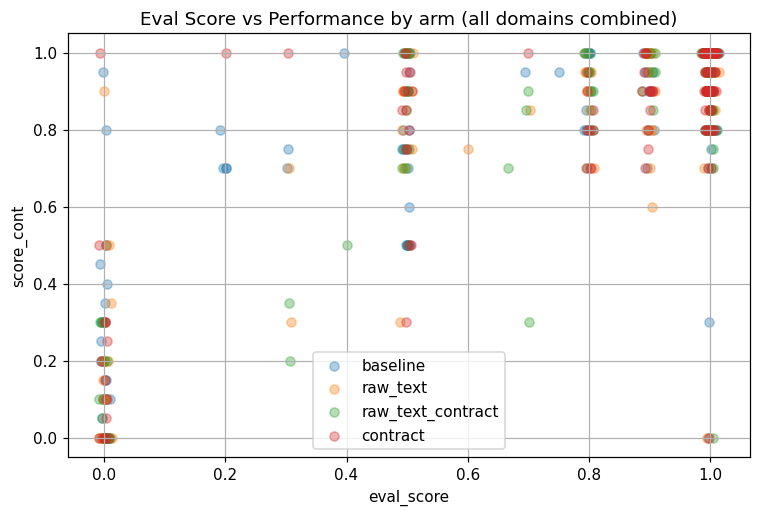

In [ ]:

def plot_arm_scatter(df, metric_x, metric_y, title):
    if df[metric_y].isna().all():
        print(f"[Skip] No data for: {title}")
        return
    # Use default colors; one plot per chart
    fig = plt.figure()
    rng = np.random.default_rng(SEED)
    for cond in df["arm"].cat.categories:
        g = df.loc[df["arm"] == cond]
        if len(g) == 0:
            continue
        # light jitter on x to avoid overplotting
        x = g[metric_x].astype(float).values + rng.normal(0, 0.005, size=len(g))
        y = g[metric_y].astype(float).values
        plt.scatter(x, y, alpha=0.35, label=str(cond))
    plt.xlabel(metric_x)
    plt.ylabel(metric_y)
    plt.title(title)
    plt.legend()
    plt.show()

if not grid_corr.empty:
    plot_arm_scatter(data, EVAL_COL, "score_cont", "Eval Score vs Performance by arm (all domains combined)")
    grid_corr



## 9) Monotonic Trend Across arms
To visualize **improvement trajectories**, we connect the **mean** metric values across the ordered arms for each domain.


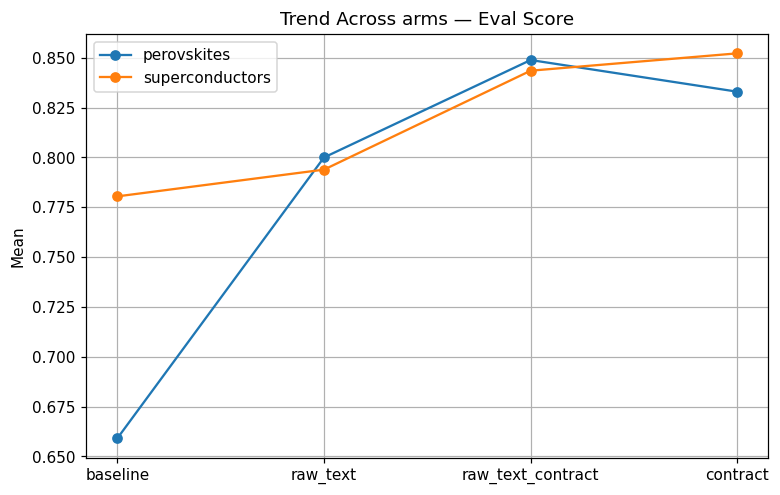

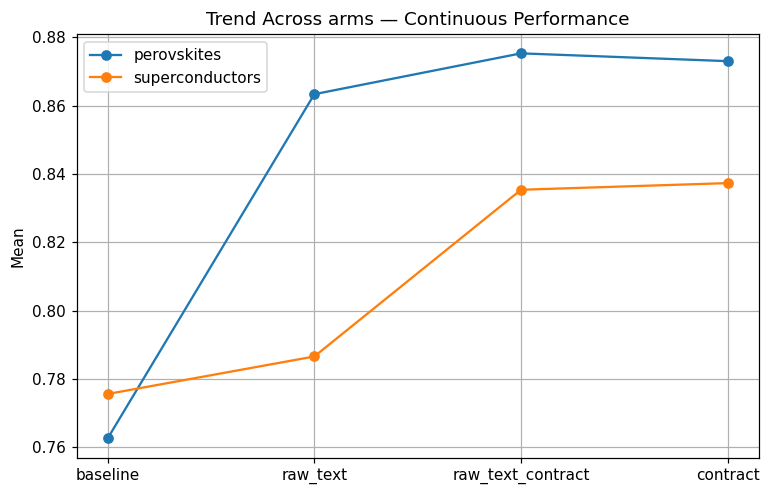

In [ ]:

def plot_line_trend(df_metric, title):
    if df_metric.empty:
        print(f"[Skip] No data for: {title}")
        return
    # Pivot so each domain becomes a line across ordered arms
    pivot = df_metric.pivot(index="arm", columns="domain", values="mean").reindex(index=df_metric["arm"].cat.categories)
    fig = plt.figure()
    for d in pivot.columns:
        plt.plot(pivot.index.astype(str), pivot[d].astype(float).values, marker="o", label=str(d))
    plt.ylabel("Mean")
    plt.title(title)
    plt.legend()
    plt.show()

plot_line_trend(agg_eval, "Trend Across arms — Eval Score")
if not agg_score.empty:
    plot_line_trend(agg_score, "Trend Across arms — Continuous Performance")



## 12) Key Findings

- **Consistent improvements** from `baseline` → `raw_text` → `raw_text_contract` → `contract` across both domains on **eval_score**.
- If predictions are present: similar **gains** in `score_cont` and **positive Spearman correlations** between `eval_score` and performance.
- **Forest plots** show **positive effect sizes** vs. baseline in both domains; **interaction CIs** include `0` (small/no domain dependence).
- **Trend lines** are monotonic or near-monotonic across domains, reinforcing **generalization**.
- Subsampling (if used) yields **stable** effect estimates.

> These aggregated results support the thesis that our **reasoning improvements are domain-independent**.
